**Name: Krish Patel**

**En No.: 18012011039**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import required libraries 
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Flatten,Dense,Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder

In [ ]:
# Load train and test csv file for image class
train = pd.read_csv('/content/drive/MyDrive/DL_Project/train.csv')
test = pd.read_csv('/content/drive/MyDrive/DL_Project/test.csv')

print(train.head())
print(test.head())
print(train['target'].value_counts())

     Image         target
0   96.jpg       manipuri
1  163.jpg  bharatanatyam
2  450.jpg         odissi
3  219.jpg      kathakali
4  455.jpg         odissi
     Image
0  508.jpg
1  246.jpg
2  473.jpg
3  485.jpg
4  128.jpg
mohiniyattam     50
odissi           49
bharatanatyam    47
kathakali        47
kuchipudi        46
sattriya         45
kathak           44
manipuri         36
Name: target, dtype: int64


In [ ]:
train.head()

,Image,target
0,96.jpg,manipuri
1,163.jpg,bharatanatyam
2,450.jpg,odissi
3,219.jpg,kathakali
4,455.jpg,odissi


Basic Histrogram plot to check number of training data for each dance form.

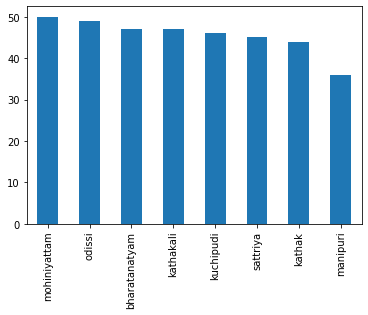

In [ ]:
#Histogram chart for target
train['target'].value_counts().plot(kind='bar')

In [ ]:
base='/content/drive/MyDrive/DL_Project'
train_dir = os.path.join(str(base)+ '/train/')
test_dir = os.path.join(str(base)+'/test/')

train_fnames = os.listdir(train_dir)
test_fnames = os.listdir(test_dir)

print(train_fnames[:9])
print(test_fnames[:9])

['1.jpg', '100.jpg', '103.jpg', '107.jpg', '104.jpg', '10.jpg', '105.jpg', '101.jpg', '102.jpg']
['110.jpg', '132.jpg', '112.jpg', '114.jpg', '108.jpg', '128.jpg', '11.jpg', '129.jpg', '119.jpg']


In [ ]:
# Images might be in different size. In this section I assigning all image at same size of 224*224
img_width = 224
img_height = 224

Below two section used for data preprocessing. We are reading image data using OpenCV and converting into numeric formate.

In [ ]:
# this function reads image from the disk,train file for image and class maping and returning output in numpy array formate
# for input and target data
def train_data_preparation(list_of_images, train, train_dir):
    """
    Returns two arrays: 
        train_data is an array of resized images
        train_label is an array of labels
    """
    train_data = [] 
    train_label = [] 
    for image in list_of_images:
        train_data.append(cv2.resize(cv2.imread(train_dir+image), (img_width,img_height), interpolation=cv2.INTER_CUBIC))
        if image in list(train['Image']):
            train_label.append(train.loc[train['Image'] == image, 'target'].values[0])
    
            
    return train_data, train_label

In [ ]:
def test_data_prepare(list_of_images, test_dir):
    """
    Returns: 
        x is an array of resized images
    """
    test_data = [] 
    
    for image in list_of_images:
        test_data.append(cv2.resize(cv2.imread(test_dir+image), (img_width,img_height), interpolation=cv2.INTER_CUBIC)) 
            
    return test_data

In [ ]:
training_data, training_labels = train_data_preparation(train_fnames, train, train_dir)

In [ ]:
training_labels[:10]

['kathak',
 'manipuri',
 'manipuri',
 'manipuri',
 'manipuri',
 'kathak',
 'manipuri',
 'manipuri',
 'manipuri',
 'manipuri']

In [ ]:
training_data[1]

array([[[16, 16, 16],
        [16, 16, 16],
        [16, 16, 16],
        ...,
        [16, 16, 16],
        [16, 16, 16],
        [16, 16, 16]],

       [[16, 16, 16],
        [16, 16, 16],
        [16, 16, 16],
        ...,
        [16, 16, 16],
        [16, 16, 16],
        [16, 16, 16]],

       [[16, 16, 16],
        [16, 16, 16],
        [16, 16, 16],
        ...,
        [16, 16, 16],
        [16, 16, 16],
        [16, 16, 16]],

       ...,

       [[37, 40, 45],
        [68, 71, 76],
        [71, 73, 81],
        ...,
        [69, 68, 72],
        [68, 67, 71],
        [38, 37, 41]],

       [[43, 46, 51],
        [79, 82, 87],
        [80, 82, 90],
        ...,
        [71, 70, 73],
        [72, 71, 74],
        [43, 42, 45]],

       [[46, 49, 54],
        [84, 87, 92],
        [83, 85, 93],
        ...,
        [71, 70, 72],
        [76, 75, 77],
        [47, 46, 48]]], dtype=uint8)

In [ ]:

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(12,12))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(label_batch[n].title())
        plt.axis('off')

Just showing loaded data for first 25 image

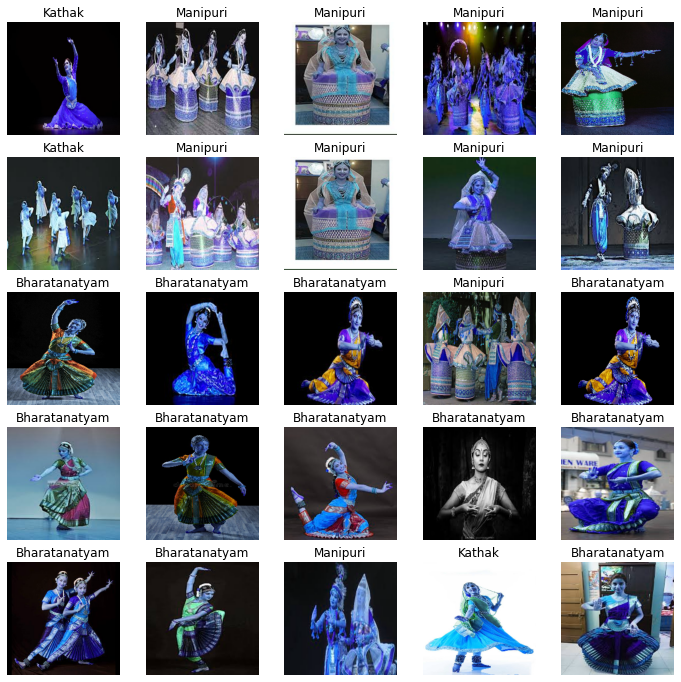

In [ ]:
show_batch(training_data, training_labels)

In [ ]:
testing_data = test_data_prepare(test_fnames, test_dir)

Using label encoder converting target class to numeric format

In [ ]:
le =LabelEncoder()
training_labels=le.fit_transform(training_labels)

In this section I am using Augumentation techniques to generate more data for given input

In [ ]:
training_labels[:10]

array([1, 4, 4, 4, 4, 1, 4, 4, 4, 4])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(training_data, training_labels, test_size=0.33, random_state=42)

In [ ]:
train_datagenerator = ImageDataGenerator(
        rescale=1. / 255,
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        rotation_range=40,  
        zoom_range = 0.20,  
        width_shift_range=0.10,  
        height_shift_range=0.10,  
        horizontal_flip=True,  
        vertical_flip=False) 


val_datagenerator=ImageDataGenerator(
        rescale=1. / 255
)

train_datagenerator.fit(X_train)
val_datagenerator.fit(X_val)
X_train=np.array(X_train)
X_val=np.array(X_val)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(243, 224, 224, 3)
(243,)
(121, 224, 224, 3)
(121,)


In below code we are loading *VGG16* weights for image classifier using transfer learning

In [ ]:
# traing using transfer learning

vggmodel =VGG16(weights='imagenet', include_top=False, input_shape = (224, 224, 3),pooling='max')

 # Print the model summary
vggmodel.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

Using already trained model for our task and bulding 2 fully connected layer with *softmax* activation function

In [ ]:
vggmodel.trainable = False
model = Sequential([
  vggmodel, 
  Dense(1024, activation='relu'),
  Dropout(0.15),
  Dense(256, activation='relu'),
  Dropout(0.15),
  Dense(8, activation='softmax'),
])

In [ ]:

reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.00001,
                                         verbose=1)

callbacks = [reduce_learning_rate]

In the below code we are compiling and traing our image data

In [ ]:
model.compile( optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history =model.fit_generator(
    train_datagenerator.flow(X_train, to_categorical(y_train,8), batch_size=16),
    validation_data=val_datagenerator.flow(X_val, to_categorical(y_val,8), batch_size=16),
    verbose=2,
    epochs=30,
    callbacks=callbacks
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/30
16/16 - 184s - loss: 2.4301 - accuracy: 0.1770 - val_loss: 2.0653 - val_accuracy: 0.1322 - lr: 0.0010 - 184s/epoch - 12s/step
Epoch 2/30
16/16 - 183s - loss: 1.9512 - accuracy: 0.2881 - val_loss: 2.5762 - val_accuracy: 0.1818 - lr: 0.0010 - 183s/epoch - 11s/step
Epoch 3/30
16/16 - 183s - loss: 1.9773 - accuracy: 0.2840 - val_loss: 1.5946 - val_accuracy: 0.4298 - lr: 0.0010 - 183s/epoch - 11s/step
Epoch 4/30
16/16 - 184s - loss: 1.5582 - accuracy: 0.4486 - val_loss: 1.6290 - val_accuracy: 0.3388 - lr: 0.0010 - 184s/epoch - 11s/step
Epoch 5/30
16/16 - 184s - loss: 1.4375 - accuracy: 0.4280 - val_loss: 1.5156 - val_accuracy: 0.4298 - lr: 0.0010 - 184s/epoch - 12s/step
Epoch 6/30
16/16 - 185s - loss: 1.2691 - accuracy: 0.5144 - val_loss: 1.5165 - val_accuracy: 0.4628 - lr: 0.0010 - 185s/epoch - 12s/step
Epoch 7/30
16/16 - 184s - loss: 1.3845 - accuracy: 0.4362 - val_loss: 1.4531 - val_accuracy: 0.5124 - lr: 0.0010 - 184s/epoch - 12s/step
Epoch 8/30

Epoch 00008: ReduceLROnPlatea

In [ ]:
history.history['val_accuracy']

[0.13223139941692352,
 0.1818181872367859,
 0.42975205183029175,
 0.3388429880142212,
 0.42975205183029175,
 0.4628099203109741,
 0.5123966932296753,
 0.4876033067703247,
 0.5950413346290588,
 0.5702479481697083,
 0.6198347210884094,
 0.64462810754776,
 0.5950413346290588,
 0.6033057570457458,
 0.6363636255264282,
 0.6363636255264282,
 0.6528925895690918,
 0.6280992031097412,
 0.6363636255264282,
 0.6528925895690918,
 0.6528925895690918,
 0.5950413346290588,
 0.6363636255264282,
 0.6363636255264282,
 0.64462810754776,
 0.6611570119857788,
 0.6694214940071106,
 0.6694214940071106,
 0.6611570119857788,
 0.6611570119857788]

Text(0.5, 1.0, 'Training and validation loss')

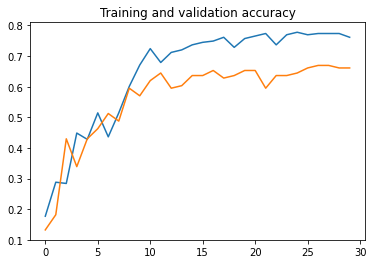

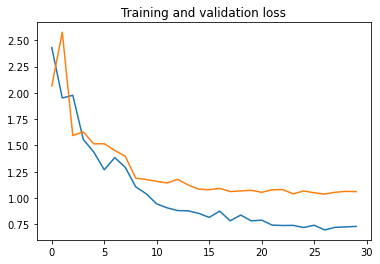

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

acc      = history.history['accuracy']
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot( epochs, acc )
plt.plot( epochs, val_acc )
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss)
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )